In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
!pip install -U keras
!pip install tensorflow-gpu==2.1.0rc0

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)
     |████████████████████████████████| 402.3MB 37kB/s 
     |████████████████████████████████| 450kB 41.8MB/s 
     |████████████████████████████████| 3.8MB 62.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=9fd387480cb2177ab30d5f7e5e4442d23c8ff5c340fd7b870b7c4be2967da4d0
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which

In [ ]:
import math
import random
import keras
from keras.layers import *
from keras.models import Sequential
from keras import Model
from keras.regularizers import *

Using TensorFlow backend.


In [ ]:
PATH = "/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/4 Class ER"

# Train set patients: 230 232 242 263 
TrainX_1 = np.load(PATH + '/ER IHC 230 Images.npy')
TrainY_1 = np.load(PATH + '/ER IHC 230 Masks.npy')
TrainX_2 = np.load(PATH + '/ER IHC 232 Images.npy')
TrainY_2 = np.load(PATH + '/ER IHC 232 Masks.npy')
TrainX_3 = np.load(PATH + '/ER IHC 242 Images.npy')
TrainY_3 = np.load(PATH + '/ER IHC 242 Masks.npy')
TrainX_4 = np.load(PATH + '/ER IHC 263 Images.npy')
TrainY_4 = np.load(PATH + '/ER IHC 263 Masks.npy')

# Test set patients: 221 229 239 246 252
TestX_1 = np.load(PATH + '/ER IHC 221 Images.npy')
TestY_1 = np.load(PATH + '/ER IHC 221 Masks.npy')
TestX_2 = np.load(PATH + '/ER IHC 229 Images.npy')
TestY_2 = np.load(PATH + '/ER IHC 229 Masks.npy')
TestX_3 = np.load(PATH + '/ER IHC 239 Images.npy')
TestY_3 = np.load(PATH + '/ER IHC 239 Masks.npy')
TestX_4 = np.load(PATH + '/ER IHC 246 Images.npy')
TestY_4 = np.load(PATH + '/ER IHC 246 Masks.npy')
TestX_5 = np.load(PATH + '/ER IHC 252 Images.npy')
TestY_5 = np.load(PATH + '/ER IHC 252 Masks.npy')

In [ ]:
def convertToLabels(data):
  data[data==85]=1
  data[data==170]=2
  data[data==255]=3

def convertFromLabels(data):
  data[data==1]=85
  data[data==2]=170
  data[data==3]=255

In [ ]:
TrainX = np.concatenate((TrainX_1, TrainX_2, TrainX_3, TrainX_4), axis=0)
TrainGT = np.concatenate((TrainY_1, TrainY_2, TrainY_3, TrainY_4), axis=0)
TrainY = np.copy(TrainGT)
convertToLabels(TrainY)
TrainY = keras.utils.to_categorical(TrainY,num_classes=4,dtype='int16')

# Train = list(zip(TrainX,TrainY))
# random.shuffle(Train)
# TrainX,TrainY = zip(*Train)
# TrainX = np.asarray(list(TrainX))
# TrainY = np.asarray(list(TrainY))

TestX = np.concatenate((TestX_1, TestX_2, TestX_3,TestX_4,TestX_5), axis=0)
TestGT = np.concatenate((TestY_1, TestY_2, TestY_3,TestY_4,TestY_5), axis=0)
TestY = np.copy(TestGT)
convertToLabels(TestY)
TestY = keras.utils.to_categorical(TestY,num_classes=4, dtype='int16')

ValidX = TrainX[1800:, : ]
ValidY = TrainY[1800:, : ]

TrainX = TrainX[0:1800, : ]
TrainY = TrainY[0:1800, : ]

In [ ]:
TrainX = TrainX.astype('float32')/255
TestX = TestX.astype('float32')/255
ValidX = ValidX.astype('float32')/255

In [ ]:
print(TrainX.shape)
print(TrainY.shape)

print(TestX.shape)
print(TestY.shape)

print(ValidX.shape)
print(ValidY.shape)

(1800, 240, 240, 3)
(1800, 240, 240, 4)
(2400, 240, 240, 3)
(2400, 240, 240, 4)
(120, 240, 240, 3)
(120, 240, 240, 4)


### **LADDERNET ARCHITECTURE**

In [ ]:
def get_conv_block(input_layer,nFilters,size):
    conv1 = Conv2D(nFilters, size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=l2(1e-4))(input_layer)
    bn1 = BatchNormalization()(conv1)
    conv2 = Conv2D(nFilters, size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=l2(1e-4))(bn1)
    bn2 = BatchNormalization()(conv2)
    return bn2
    
def get_UNET(input_layer,nFilters,flag): 

    block1 = get_conv_block(input_layer[0],nFilters,3)
    mp1 = MaxPooling2D(pool_size=(2, 2))(block1)
    dr1 = Dropout(0.1)(mp1)
   
    if(flag==1):
      dr1 = concatenate([dr1,input_layer[1]])

    block2 = get_conv_block(dr1,nFilters*2,3)
    mp2 = MaxPooling2D(pool_size=(2, 2))(block2)
    dr2 = Dropout(0.1)(mp2)

    if(flag==1):
      dr2 = concatenate([dr2,input_layer[2]])
   
    block3 = get_conv_block(dr2,nFilters*4,3)
    mp3 = MaxPooling2D(pool_size=(2, 2))(block3)
    dr3 = Dropout(0.1)(mp3)

    if(flag==1):
      dr3 = concatenate([dr3,input_layer[3]])
       
    block4 = get_conv_block(dr3,nFilters*8,3)
    mp4 = MaxPooling2D(pool_size=(2, 2))(block4)
    dr4 = Dropout(0.1)(mp4)

    conv5 = Conv2D(nFilters*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=l2(1e-4))(dr4)
    conv5 = Conv2D(nFilters*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=l2(1e-4))(conv5)

    up1 = Conv2DTranspose(nFilters*8,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(conv5)
    cat1 = concatenate([block4, up1, mp3])
    dr1 = Dropout(0.1)(cat1)
    block5 = get_conv_block(dr1,nFilters*8,3)

    up2 = Conv2DTranspose(nFilters*4,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block5)
    b4_upsample = Conv2DTranspose(nFilters*4,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block4)
    cat2 = concatenate([block3, up2, b4_upsample, mp2])
    dr2 = Dropout(0.1)(cat2)
    block6 = get_conv_block(dr2,nFilters*4,3)
    
    up3 = Conv2DTranspose(nFilters*2,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block6)
    b3_upsample = Conv2DTranspose(nFilters*2,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block3)
    cat3 = concatenate([block2, up3, mp1, b3_upsample])
    dr3 = Dropout(0.1)(cat3)
    block7 = get_conv_block(dr3,nFilters*2,3)
    
    up4 = Conv2DTranspose(nFilters,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block7)
    b2_upsample = Conv2DTranspose(nFilters,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block2)
    cat4 = concatenate([block1, up4, b2_upsample])
    dr4 = Dropout(0.1)(cat4)
    block8 = get_conv_block(dr4,nFilters,3)

    conv10 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=l2(1e-4))(block8)
    conv11 = Conv2D(4,(1,1), activation='softmax', padding = 'same',kernel_regularizer=l2(1e-4))(conv10)

    return (conv11, block7, block6, block5)

def get_model(input_shape,nFilters1,nFilters2):

    input_layer = Input(shape=input_shape)
    out1,out2,out3,out4 = get_UNET([input_layer],nFilters1,0)

    model = Model(input_layer,out1)
    return model

In [ ]:
model = get_model((240,240,3),16,4)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 240, 240, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 240, 16) 2320        batch_normalization_1[0][0]      
____________________________________________________________________________________________

### **END OF MODEL**

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

In [ ]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('Checkpoint.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.001, decay=0.0, amsgrad=True)

In [ ]:
# def tversky_loss(y_true, y_pred):
#     alpha = 0.45
#     beta  = 0.55
    
#     ones = K.ones(K.shape(y_true))
#     p0 = y_pred      # proba that voxels are class i
#     p1 = ones-y_pred # proba that voxels are not class i
#     g0 = y_true
#     g1 = ones-y_true
    
#     num = K.sum(p0*g0, (0,1,2))
#     den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
#     T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
#     Ncl = K.cast(K.shape(y_true)[-1], 'float32')
#     return Ncl-T

# def combined_loss(y_true, y_pred):
#   return (0.25*K.categorical_crossentropy(y_true, y_pred))+(0.75*tversky_loss(y_true, y_pred))

In [ ]:
def tversky_loss(y_true, y_pred):
    alpha = 0.7
    beta  = 0.3
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    # 
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky_loss(y_true, y_pred)
    return K.pow(( tv), gamma)

def combined_loss(y_true, y_pred):
  return (0.2*K.categorical_crossentropy(y_true, y_pred))+(0.8*focal_tversky_loss(y_true, y_pred))

In [ ]:
batch_size = 16
def get_batch(batch_size, X_train, Y_train): 
    size_batch = batch_size
    last_index = len(X_train) - 1
    x_train = X_train
    y_train = Y_train 
    while True:
        batch_data = [[],[]]
        for i in range(0, size_batch):
            random_index = random.randint(0, last_index)
            batch_data[0].append(x_train[random_index])
            batch_data[1].append(y_train[random_index])

        yield (np.array(batch_data[0]), np.array(batch_data[1]))     

In [ ]:
from keras import backend as K      
model.compile(loss=combined_loss, optimizer= optimizer , metrics=[dice_coef,'accuracy'])

In [ ]:
num_epoch = 5
datagen = get_batch(batch_size, TrainX, TrainY)
MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models/4 Class/ER"
n_points = len(TrainX)
history = model.fit(datagen, 
                validation_data = (ValidX, ValidY),
                epochs=num_epoch,steps_per_epoch = math.ceil(n_points / batch_size), callbacks =[es,mc],  shuffle =True)
model.save(MODELS_PATH + '/Laddernet_31MAY.h5')

Epoch 1/5
113/113 [==============================] - 54s 479ms/step - loss: 2.4625 - dice_coef: 0.4112 - accuracy: 0.7279 - val_loss: 2.2058 - val_dice_coef: 0.5474 - val_accuracy: 0.6838

Epoch 00001: val_loss improved from inf to 2.20581, saving model to Checkpoint.h5
Epoch 2/5
113/113 [==============================] - 36s 315ms/step - loss: 2.0683 - dice_coef: 0.7815 - accuracy: 0.8853 - val_loss: 2.2435 - val_dice_coef: 0.6344 - val_accuracy: 0.6576

Epoch 00002: val_loss did not improve from 2.20581
Epoch 3/5
113/113 [==============================] - 36s 315ms/step - loss: 1.9108 - dice_coef: 0.8806 - accuracy: 0.8954 - val_loss: 2.0480 - val_dice_coef: 0.6973 - val_accuracy: 0.7260

Epoch 00003: val_loss improved from 2.20581 to 2.04798, saving model to Checkpoint.h5
Epoch 4/5
 55/113 [=============>................] - ETA: 17s - loss: 1.8496 - dice_coef: 0.9026 - accuracy: 0.9190

KeyboardInterrupt: ignored

In [ ]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
xc=range(len(train_loss))
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train','val'])

In [ ]:
MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models/4 Class/ER/"
model1 = keras.models.load_model(MODELS_PATH +'/Laddernet_A_29MAY.h5',custom_objects={ 'combined_loss': combined_loss, 'dice_coef': dice_coef })

In [ ]:
trainResult = model.predict(TrainX, batch_size=8)
validResult = model.predict(ValidX,batch_size=8)
testResult = model.predict(TestX,batch_size=8)

In [ ]:
trainResult = np.argmax(trainResult,axis=-1)
validResult = np.argmax(validResult,axis=-1)
testResult = np.argmax(testResult,axis=-1)

trainOneHot = keras.utils.to_categorical(trainResult,num_classes=4,dtype='int16')
validOneHot = keras.utils.to_categorical(validResult,num_classes=4,dtype='int16')
testOneHot = keras.utils.to_categorical(testResult,num_classes=4,dtype='int16')

convertFromLabels(trainResult)
convertFromLabels(validResult)
convertFromLabels(testResult)

print(trainResult.shape)
print(validResult.shape)
print(testResult.shape)

(1800, 240, 240)
(120, 240, 240)
(2400, 240, 240)


In [ ]:
from sklearn import metrics
trial1 = np.reshape(TrainY,(-1, TrainY.shape[3]))
trial2 = np.reshape(trainOneHot,(-1, trainOneHot.shape[3]))

print("TRAIN")
print(metrics.classification_report(trial1.argmax(axis = 1), trial2.argmax(axis = 1)))
train_JC = metrics.jaccard_score(trial1.argmax(axis=1),trial2.argmax(axis=1),average='weighted')
print("JACCARD COEFFICIENT:  ",train_JC)

trial1 = np.reshape(TestY,(-1, TestY.shape[3]))
trial2 = np.reshape(testOneHot,(-1, testOneHot.shape[3]))

print("\n\nTEST")
print(metrics.classification_report(trial1.argmax(axis = 1), trial2.argmax(axis = 1)))
test_JC = metrics.jaccard_score(trial1.argmax(axis=1),trial2.argmax(axis=1),average='weighted')
print("JACCARD COEFFICIENT:  ",test_JC)

TRAIN
              precision    recall  f1-score   support

           0       0.99      0.98      0.98  91970674
           1       0.37      0.51      0.43   1284509
           2       0.54      0.73      0.62   4182920
           3       0.84      0.71      0.77   6241897

    accuracy                           0.94 103680000
   macro avg       0.68      0.73      0.70 103680000
weighted avg       0.95      0.94      0.95 103680000

JACCARD COEFFICIENT:   0.9135229908737711


TEST
              precision    recall  f1-score   support

           0       0.99      0.99      0.99 131085645
           1       0.25      0.49      0.34    676269
           2       0.55      0.37      0.45   2009481
           3       0.73      0.81      0.76   4468605

    accuracy                           0.97 138240000
   macro avg       0.63      0.67      0.63 138240000
weighted avg       0.97      0.97      0.97 138240000

JACCARD COEFFICIENT:   0.9522069391396645


In [ ]:
def stitchMaskPatches(pieces):
  k = 0
  reconstructed_img = np.ones([1440,1920])
  for r in range(6):
    row = r * 240
    for c in range(8):
      col = c * 240
      reconstructed_img[row:row+240,col:col+240] = pieces[k]
      k = k + 1
  return reconstructed_img


def stitchImagePatches(pieces):
  k = 0
  reconstructed_img = np.ones([1440,1920,3])
  for r in range(6):
    row = r * 240
    for c in range(8):
      col = c * 240
      reconstructed_img[row:row+240,col:col+240,:] = pieces[k]
      k = k + 1
  return reconstructed_img

In [ ]:
def saveNumpyOutput(mask, Patient_array,Patient_length,title):
  idx = 0
  for i in range(len(Patient_length)):
    temp = []
    for j in range(Patient_length[i]):
      print(j)
      final_output = mask[idx:idx+48]
      idx = idx + 48
      final_output = stitchMaskPatches(final_output)
      temp.append(final_output)
    final_output = np.asarray(temp)
    np.save("/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays/Predicted Output/ER/UNET/4 Class/LadderNet_29MAY/" + title + Patient_array[i], final_output)

In [ ]:
# saving predicted outputs as numpy arrays for test images

Train = ['230','232','242','263']
Train_len = [10,10,10,10]
Test  = ['221', '229', '239', '246','252']
Test_len = [10,10,10,10,10]

trainResult = np.append(trainResult,validResult,axis=0)
saveNumpyOutput(trainResult, Train, Train_len,"Train/")
saveNumpyOutput(testResult, Test, Test_len,"Test/")

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(1440, 1920, 3)
(1440, 1920)
(1440, 1920)
[  0.  85. 170. 255.]


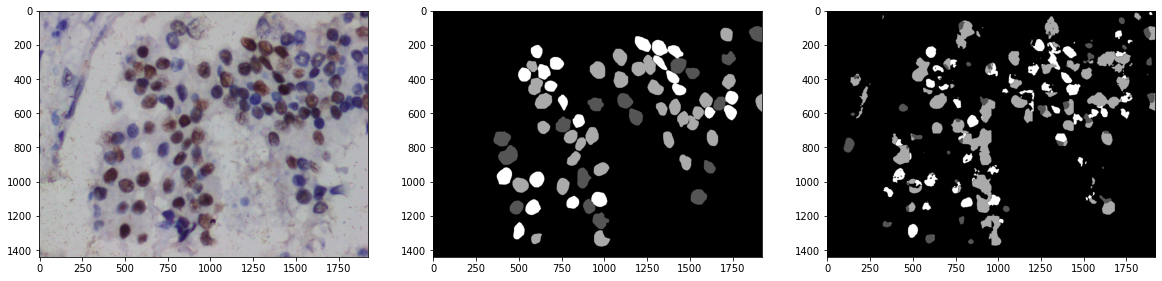

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


plt.figure(figsize=(20,20))
id = 48   # enter between 0- 50 since there are 5 patients with 10 images each

id = id * 48
final_input = TestX[id:id+48]
Mask_input = TestGT[id:id+48]
final_output = testResult[id:id+48]

final_input = stitchImagePatches(final_input)
Mask_input =  stitchMaskPatches(Mask_input)
final_output = stitchMaskPatches(final_output)

print(final_input.shape)
print(final_output.shape)
print(Mask_input.shape)

print(np.unique(final_output))
copy1  = np.copy(final_input)
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
final_input = np.reshape(copy2,(1440, 1920,3))
final_input = cv2.cvtColor(final_input,cv2.COLOR_BGR2RGB)

plt.subplot(131).imshow(final_input)
plt.subplot(132).imshow(Mask_input,'gray')
plt.subplot(133).imshow(final_output,'gray')

(1440, 1920, 3)
(1440, 1920)
(1440, 1920)
[  0.  85. 170. 255.]


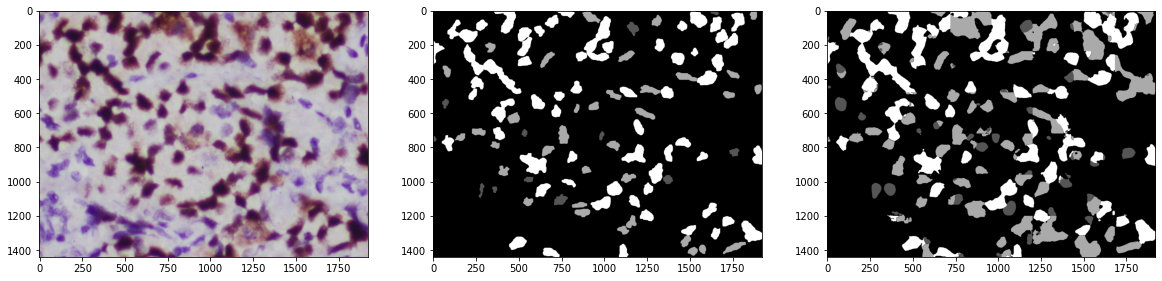

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


plt.figure(figsize=(20,20))
id = 25  # enter between 0- 40 since there are 4 patients with 10 images each

id = id * 48
final_input = TrainX[id:id+48]
Mask_input = TrainGT[id:id+48]
final_output = trainResult[id:id+48]

final_input = stitchImagePatches(final_input)
Mask_input =  stitchMaskPatches(Mask_input)
final_output = stitchMaskPatches(final_output)

print(final_input.shape)
print(final_output.shape)
print(Mask_input.shape)

print(np.unique(final_output))
copy1  = np.copy(final_input)
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
final_input = np.reshape(copy2,(1440, 1920,3))
final_input = cv2.cvtColor(final_input,cv2.COLOR_BGR2RGB)

plt.subplot(131).imshow(final_input)
plt.subplot(132).imshow(Mask_input,'gray')
plt.subplot(133).imshow(final_output,'gray')